# Notebook used to tune a SGBM algorithm to obtain as detailed as possible pointclouds
Running all the cells in this notebook should generate the necessary disparity maps for generating pointclouds. 
**BEWARE**: Before running this notebook, folders "pointclouds" and "depthMaps" should be created inside the data folder of the repo.  

In [4]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

In [5]:
# READ IN ALL THE DATA
DATASET_PATH = "../data/final_project_2023_rect/"
DATASET_NOT_REC = "final_project_data/"

## Get the images
left_images = glob.glob(DATASET_PATH + "/seq_01/image_02/data/*.png")
right_images = glob.glob(DATASET_PATH + "/seq_01/image_03/data/*.png")
left_images.sort()
right_images.sort()

left_images_not_rectified = glob.glob(DATASET_NOT_REC + "/seq_01/image_02/data/*.png")
right_images_not_rectified = glob.glob(DATASET_NOT_REC + "/seq_01/image_03/data/*.png")

maxTimeStep = len(right_images)
print(maxTimeStep)

old_disparity = new_disparity = None

145


In [6]:
def calculateQManually(p1, p2):
    """Function to calculate the disparity to depth mapping matrix Q manually
       based on the two camera matrices

    Args:
        p1 (ndarray): 3x4 camera matrix of the left camera
        p2 (ndarray): 3x4 camera matrix of the right camera

    Returns:
        Q: the depth-to-disparity matrix
    """    
    # f = 707.0493; tx = 0.54; cx1 = 601.6086; cy = 183.1104; cx2 = -334.1081
    f = p1[0,0]             # Calculate the focal length
    tx = 0.54         # Calculate the baseline
    cx1 = p1[0,2]
    cx2 = p2[0,2]
    cy =  p1[1,2]
    # Calculate the Q matrix
    Q = np.float32([[1, 0,  0,  -cx1],
                    [0, 1, 0,  -cy],
                    [0, 0,  0,     f],
                    [0, 0, -1/tx, (cx1-cx2)/tx]])
    return Q

In [7]:
def readAllColorMatrices():
    """Function to read all the interesting matrices in the calib_cam_to_cam.txt file.
       File should be inside data/final_project_2023_rect

    Returns:
        matrices: all the relevant matrices for the colored images
    """    
    
    path = "../data/final_project_2023_rect/calib_cam_to_cam.txt"
    
    with open(path, 'r') as f:
        fin = f.readlines()
        for line in fin:
            if line[:4] == "R_02":
                rotation2 = np.array(line[6:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:4] == "R_03":
                rotation3 = np.array(line[6:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:4] == "K_02":
                intrinsic2 = np.array(line[6:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:4] == "K_03":
                intrinsic3 = np.array(line[6:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:4] == "T_02":
                translation2 = np.array(line[6:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:4] == "T_03":
                translation3 = np.array(line[6:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:9] == "S_rect_02":
                imageSize2 = np.array(line[11:].strip().split(" ")).astype('float32')
            elif line[:9] == "S_rect_03":
                imageSize3 = np.array(line[11:].strip().split(" ")).astype('float32')
            elif line[:9] == "R_rect_02":
                rectRot2 = np.array(line[11:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:9] == "R_rect_03":
                rectRot3 = np.array(line[11:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:9] == "P_rect_02":
                camMatrix2 = np.array(line[11:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:9] == "P_rect_03":
                camMatrix3 = np.array(line[11:].strip().split(" ")).astype('float32').reshape(3,-1)
    
    return rotation2, rotation3, translation2, translation3, imageSize2, imageSize3, \
            rectRot2, rectRot3, intrinsic2, intrinsic3, camMatrix2, camMatrix3

In [8]:

def semiGlobalMatchMap(left_img, right_img):
    """Function for tuning an SGBM object to compute the disparity maps

    Args:
        left_img (ndarray): color image of the left camera
        right_img (ndarray): color image of the right camera

    Returns:
        leftMatcher: the SGMBM object
        dispL: the disparity map
    """    
    def nothing(x):
        pass
    
    cv2.namedWindow('disp',cv2.WINDOW_NORMAL)
    cv2.resizeWindow('disp',800,800)
    
    ###### Default values ######
    blockSize = 7          # odd number, usually in range 3-11
    minDisparity = 5      
    numDisparities = 6  # max disparity minus minDisparity, must be divisible by 16
    uniquenessRatio = 1

    # Affects the noise
    speckleRange = 2       # multiplied by 16 implicitly, 1 or 2 usually good
    speckleWindowSize = 224 # 50-200 range
    ###################
    
    cv2.createTrackbar('minDisparity','disp',minDisparity,17,nothing)
    cv2.createTrackbar('numDisparities','disp',numDisparities,17,nothing)
    cv2.createTrackbar('blockSize','disp',blockSize,20,nothing)
    cv2.createTrackbar('uniquenessRatio','disp',uniquenessRatio,10,nothing)
    cv2.createTrackbar('speckleRange','disp',speckleRange,5,nothing)
    cv2.createTrackbar('speckleWindowSize','disp',speckleWindowSize,250,nothing)
    
    # Creating an object of StereoBM algorithm
    leftMatcher = cv2.StereoSGBM_create()
    
    while True:
        
        # Updating the parameters based on the trackbar positions
        numDisparities = cv2.getTrackbarPos('numDisparities','disp')*16
        numDisparities = 16 if numDisparities == 0 else numDisparities
        blockSize = cv2.getTrackbarPos('blockSize','disp')
        if blockSize % 2 == 0:
            blockSize += 1

        if blockSize < 5:
            blockSize = 5

        uniquenessRatio = cv2.getTrackbarPos('uniquenessRatio','disp')
        speckleRange = cv2.getTrackbarPos('speckleRange','disp')
        speckleWindowSize = cv2.getTrackbarPos('speckleWindowSize','disp')
        minDisparity = cv2.getTrackbarPos('minDisparity','disp')
            
        # Setting the updated parameters before computing disparity map
        leftMatcher.setNumDisparities(numDisparities)
        leftMatcher.setBlockSize(blockSize)
        leftMatcher.setUniquenessRatio(uniquenessRatio)
        leftMatcher.setSpeckleRange(speckleRange)
        leftMatcher.setSpeckleWindowSize(speckleWindowSize)
        leftMatcher.setMinDisparity(minDisparity)
        # P1 and P2 values from OpenCV documentation
        leftMatcher.setP1(8*3*blockSize**2)
        leftMatcher.setP2(32*3*blockSize**2)
        
        # Calculating disparity using the stereoBM algorithm
        leftDisparity =  leftMatcher.compute(left_img, right_img).astype(np.float32)
        dispL = cv2.ximgproc.getDisparityVis(leftDisparity)

        # Displaying the disparity map
        cv2.imshow("disp",dispL)
    
        # Close window using esc key
        if cv2.waitKey(1) == 27:
            break 
    cv2.destroyAllWindows()
    return leftMatcher, dispL

In [18]:
def export_pointcloud(disparity_map, colors, filename):
    """Function for exporting the point cloud to a .ply file inside the pointclouds folder

    Args:
        disparity_map (ndarray): disparity map from the stereo images
        colors (ndarray): left RGB image
        filename (str): name of the file to be saved inside the pointclouds folder
    """    
    
    def write_ply(fn, verts, colors):
        ply_header = '''ply
        format ascii 1.0
        element vertex %(vert_num)d
        property float x
        property float y
        property float z
        property uchar red
        property uchar green
        property uchar blue
        end_header
        '''
        colors = colors.copy()
        verts = verts.reshape(-1, 3)
        verts = np.hstack([verts, colors])
        with open("../data/pointclouds/"+fn, 'wb') as f:
            f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
            np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')
    
    rot2, rot3, trans2, trans3, imgSize2, imgSize3, rectRot2, rectRot3,\
    k2, k3, cam2, cam3,  = readAllColorMatrices() 
    
    cam2 = cam2[:,:3]
    cam3 = cam3[:,:3]
    Tmat = np.array([0.54, 0.0, 0.0])   # From the KITTI Sensor setup, in metres 
    cvQ = np.zeros((4,4))
    cv2.stereoRectify(cameraMatrix1=cam2, cameraMatrix2=cam3, distCoeffs1=0, distCoeffs2=0,
                        imageSize=colors.shape[:2], R=np.identity(3), T=Tmat, 
                        R1=None, R2=None,P1=None, P2=None, Q=cvQ)
    
    points = cv2.reprojectImageTo3D(disparity_map, cvQ, handleMissingValues=False)
    #reflect on x axis
    reflect_matrix = np.identity(3)
    reflect_matrix[0] *= -1
    points = np.matmul(points,reflect_matrix)
    
    colors = cv2.cvtColor(colors, cv2.COLOR_BGR2RGB) # Extract colors from image
    mask = disparity_map > disparity_map.min()
    out_points = points[mask]
    out_colors = colors[mask]
    
    #filter by dimension
    idx = np.fabs(out_points[:,0]) < 4.5
    out_points = out_points[idx]
    out_colors = out_colors.reshape(-1, 3)
    out_colors = out_colors[idx]

    write_ply(filename, out_points, out_colors)
    print(f'{filename} saved')
    
    return out_points, reflect_matrix, idx, cam3, mask

In [10]:
def pointcloudToImage(points, reflectMat, idx, cam3, mask, left_img, right_img):
    """Function to reproject the pointcloud back to the original image

    Args:
        points (pointcloud): the 3D points, gotten from export_pointcloud function
        reflectMat (ndarray): reflection matrix, gotten from export_pointcloud function
        idx (ndarray): index of the points, gotten from export_pointcloud function
        cam3 (ndarray): camera matrix of the right camera
        mask (ndarray): mask of the disparity map
        left_img (ndarray): left color image
        right_img (ndarray): right color image

    Returns:
        ndarray: the reprojected image
    """    
    
    # Verify the pointcloud by going back to the original image based on the points
    reflected_pts = np.matmul(points, reflectMat)
    projected_img,_ = cv2.projectPoints(reflected_pts, np.identity(3), np.array([0., 0., 0.]), \
                            cam3[:3,:3], np.array([0., 0., 0., 0.]))
    projected_img = projected_img.reshape(-1, 2)

    blank_img = np.zeros(left_img.shape, 'uint8')
    img_colors = right_img[mask][idx].reshape(-1,3)

    for i, pt in enumerate(projected_img):
        pt_x = int(pt[0])
        pt_y = int(pt[1])
        if pt_x > 0 and pt_y > 0:
            # use the BGR format to match the original image type
            col = (int(img_colors[i, 2]), int(img_colors[i, 1]), int(img_colors[i, 0]))
            cv2.circle(blank_img, (pt_x, pt_y), 1, col)
    return blank_img

In [11]:
## Extract all the disparity maps

def createDisparityMaps(left_images, right_images, time=0):
    """Function creating all the disparity maps from the given stereo images

    Args:
        left_images (glob): path to the left images
        right_images (glob): path to the right images
        time (int, optional): Time to display the maps when they're created. 
                              Defaults to 0.

    Returns:
        list: a list of all the disparity maps without visual convenience function used,
              i.e. these disparity maps should not be displayed (use rather the files saved).
              These disparity maps should be used for the point cloud generation.
    """    
    allDisparityMaps = []
    
    # Create the SGBM object with known good values (from tuning, see semiGlobalMatchMap function)
    numDisp, minDisp, blockS, unique, speckR, speckWindow = 6*16, 5, 7, 1, 2, 224
    P1, P2 = 8*3*blockS**2, 32*2*blockS**2

    leftMatcher = cv2.StereoSGBM_create(numDisparities=numDisp, minDisparity=minDisp, blockSize=blockS,
                                    uniquenessRatio=unique, speckleRange=speckR, 
                                    speckleWindowSize=speckWindow, 
                                    P1=8*3*blockS**2, P2=32*3*blockS**2)

    for fname1, fname2 in zip(left_images, right_images):
        left_img = cv2.imread(fname1)
        right_img = cv2.imread(fname2)
        left_img_blur = cv2.blur(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY), (5,5))
        right_img_blur = cv2.blur(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY), (5,5))
        
        # Calculate the disparity map and apply WLS filter
        rightMatcher = cv2.ximgproc.createRightMatcher(leftMatcher)

        # Calculating disparity using the stereoBM algorithm
        leftDisparity =  leftMatcher.compute(left_img_blur, right_img_blur)
        rightDisparity = rightMatcher.compute(right_img_blur, left_img_blur)

        # Create a WLS (weighted least squares) filter (source: https://docs.opencv.org/3.4/d3/d14/tutorial_ximgproc_disparity_filtering.html) 
        wlsFilter = cv2.ximgproc.createDisparityWLSFilter(leftMatcher)
        wlsFilter.setLambda(8000)       # The tuning parameter, depends on the range of disparity values
        wlsFilter.setSigmaColor(0.7)    # Adjusts the filter's sensitivity to edges in the image (between 0.8 and 2.0 usually good)
        filteredDisparity = wlsFilter.filter(leftDisparity, left_img_blur, None, rightDisparity)
        visFiltered = cv2.ximgproc.getDisparityVis(filteredDisparity)
        allDisparityMaps.append(filteredDisparity)
        
        # Only show the images if we want to
        if time != 0:
            # Convenience function to get nicer visualisations of the disparity maps
            visL = cv2.ximgproc.getDisparityVis(leftDisparity)
            # Show both images, left next to right
            both = np.concatenate((visL, visFiltered), axis=0)
            cv2.imshow('Corners', both)
            cv2.waitKey(time) 
            
        # Save the depth map to file, given the filename it was read from
        cv2.imwrite("../data/depthMaps/depthMap_" + fname1.split("/")[-1], visFiltered)
        
    cv2.destroyAllWindows()
    
    return allDisparityMaps

#### Run the cell below to tune the SGBM parameters yourself

In [131]:

# frame = 1
# left_img = cv2.imread(left_images[frame])
# right_img = cv2.imread(right_images[frame])
# # Blur det images to reduce noise for the stereo matching
# left_img_blur = cv2.blur(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY), (5,5))
# right_img_blur = cv2.blur(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY), (5,5))
# sgbmObject, disparityMap = semiGlobalMatchMap(left_img_blur, right_img_blur)
# plt.imshow(disparityMap, "gray")

## Before running the below cell generating all the depth maps, these things need to be in order
1. The path to the rectified images should be updated if not in the same place
2. Two folders named "depthMaps" and "pointclouds" should be created inside the "data" folder of the repo. 
3. Finally the depth maps will be saved to data/depthMaps/NAME_OF_MAP.png

In [14]:

left_images = glob.glob("../data/final_project_2023_rect/seq_01/image_02/data/*.png")
right_images = glob.glob("../data/final_project_2023_rect/seq_01/image_03/data/*.png")
left_images.sort()
right_images.sort()
# Set time to some value if you want to display the disparity maps being created
allMaps = createDisparityMaps(left_images, right_images, time=0)

**IMPORTANT!!** The disparity maps inside the list should be used for pointcloud generation, whilst the saved files can be used for visualizing. **IMPORTANT!!**

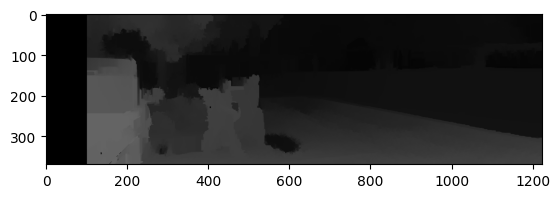

In [15]:
# Load a depth map and display it
# NOTE: here we're displaying the file
map = cv2.imread("../data/depthMaps/depthMap_000000.png")
plt.imshow(map, 'gray')

In [19]:
# Extract a pointcloud from a depth map, saving it to a file
# NOTE: Here we're using the list
out_points, reflect_matrix, idx, cam3, mask = export_pointcloud(allMaps[0], cv2.imread(left_images[0]), 
                                                                filename="exampleCloud.ply")

exampleCloud.ply saved


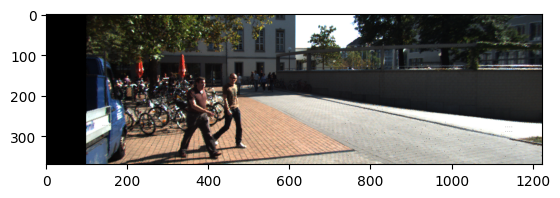

In [21]:
# Reproject the pointcloud to the image plane
blank_img = pointcloudToImage(out_points, reflect_matrix, idx, cam3, mask, cv2.imread(left_images[0]), 
                                    cv2.imread(right_images[0]))
plt.imshow(blank_img)

The picture above should be recreated to the original picture without flaws.